In [20]:
import pandas as pd
import numpy as np
import plotly.io as pio
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
pio.renderers.default = 'notebook'
sns.set_palette('viridis')
pd.set_option('display.max_rows', 30)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":10,"axes.labelsize":8}) 


загрузим очищенный датасет

In [3]:
df = pd.read_csv('clear_dataset.csv', index_col=0)
df.head()

,title,year,age,run,history,owners_pts,modification,volume,engine_type,transmission,...,wheel,exchange,mark,accident,other_history,tech_history,sold,pts_type,price,horse_power
0,Kia K900 3.3 AT,2019,II,91037,8.0,2,3.3 4WD AT,3.3,Бензин,Автомат,...,Левый,Возможен,соответствует,1,2,4,1,Другое,2999000,249
1,Mercedes-Benz V-класс 2.1 AT,2017,W447,95250,19.0,2,V 250 d 2.1 4MATIC AT L3,2.1,Дизель,Автомат,...,Левый,Не интересует,соответствует,0,2,19,2,Оригинал,5650000,190
2,Opel Astra GTC 1.4 AT,2013,J рестайлинг,113000,6.0,2,1.4 Turbo AT,1.4,Бензин,Автомат,...,Левый,Возможен,ниже,1,2,5,3,Другое,699000,140
3,Volkswagen Tiguan 2.0 AT,2015,I рестайлинг,165000,9.0,2,2.0 TDI 4Motion AT,2.0,Дизель,Автомат,...,Левый,Возможен,ниже,0,2,5,1,Другое,1195000,140
4,Ford Kuga 1.5 AT,2018,II рестайлинг,103000,16.0,1,1.5 EcoBoost 4WD AT,1.5,Бензин,Автомат,...,Левый,другое,соответствует,0,1,10,1,Оригинал,1780000,150


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698 entries, 0 to 1697
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1698 non-null   object 
 1   year           1698 non-null   int64  
 2   age            1698 non-null   object 
 3   run            1698 non-null   int64  
 4   history        1698 non-null   float64
 5   owners_pts     1698 non-null   object 
 6   modification   1698 non-null   object 
 7   volume         1698 non-null   float64
 8   engine_type    1698 non-null   object 
 9   transmission   1698 non-null   object 
 10  gear           1698 non-null   object 
 11  body           1698 non-null   object 
 12  color          1698 non-null   object 
 13  wheel          1698 non-null   object 
 14  exchange       1698 non-null   object 
 15  mark           1698 non-null   object 
 16  accident       1698 non-null   int64  
 17  other_history  1698 non-null   int64  
 18  tech_history 

Большинство переменных в нашем датасете являются категориальными, однако есть несколько числовых переменных. Рассмотрим распределение числовых и категориальных признаков, чтобы лучше понимать соотношение категорий и значений

In [37]:

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_cols = df.select_dtypes(include=['object']).columns.to_list()


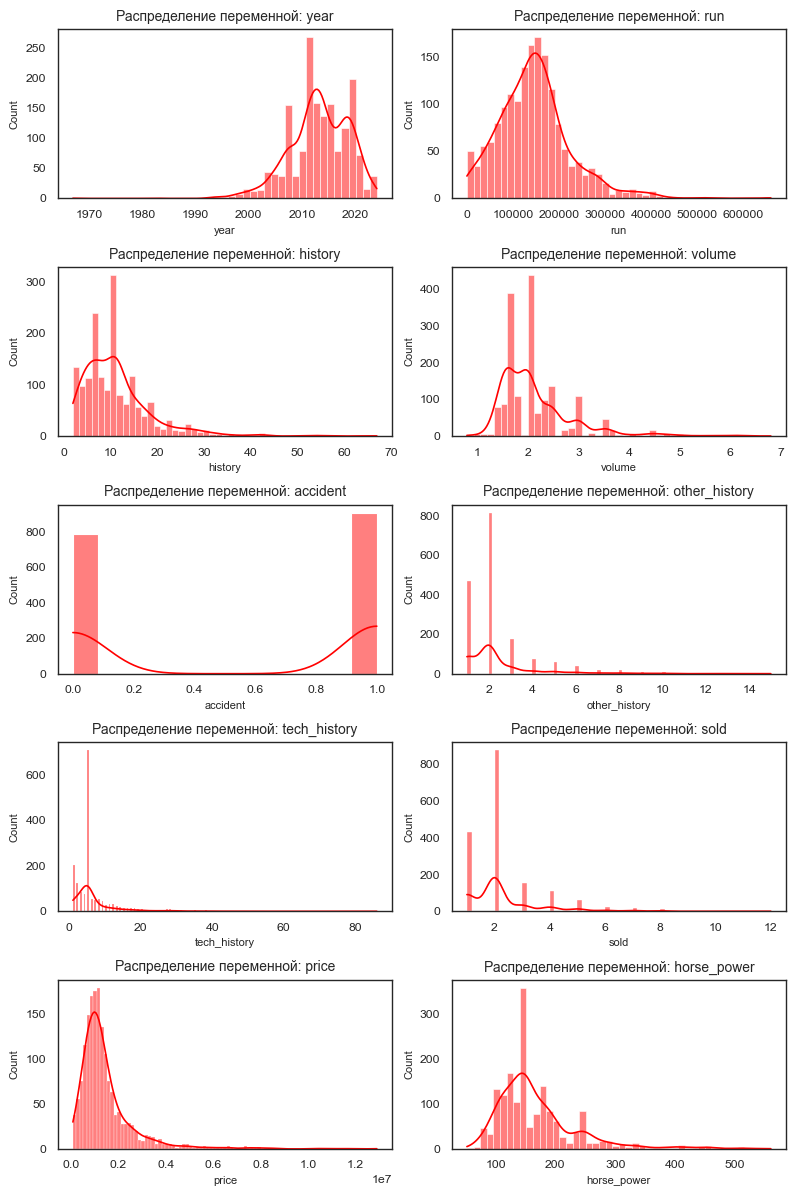

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='red') 
    axes[i].set_title(f'Распределение переменной: {col}') 
    axes[i].tick_params(axis='both')
    

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- Видим, что в переменная года выпуска распределена достаточно неравномерно и присутствуют выбросы  2000х годов.
- Пробег распределен более равномерно, хоть и присутствует перекос влево, как и у переменных истории пробега, количества лошадиных сил и цены, а также большое число выборосов справа.
- Объем двигателя распределен менее равномерно и с перекосом влево
- Число записей о техобслуживании (что можно отнести в категориальный признак) имеет большое число выбросов и выделяющуюся категорию около 10 => требуется отдельно рассмотреть релевантность использования данной переменной

*Категориальные признаки*
- Налиие или отсутвие информации о ДТП (accident) распределена приблизительно равномерно
- other_history – история владельцев - имеет несколько мелких категорий на числе владельцев больше 6
- Число продаж имеет явно самое частое значение – 2, однако значение меньше 6 также встречаются часто. В целом число продаж на авито и число предыдущех владельцев распределены примрено одинаково (есть отличие около 5-6 владельцев/продаж), из чего можем сделать предположение о том что практически всегда машины, продающиеся на авито несколько раз имеют нескольких владельцев-пользователей Авито

Сделаем то же самое для текстовых категорий, но не будем брать в расчет название (title), age (поколение) и modification – модификация автомобиля, так как в данных признаках слишком много значений и мы рассмотрим их отдельно

In [45]:
cat_cols_display = [i for i in cat_cols if i not in ['title', 'age', 'modification']]

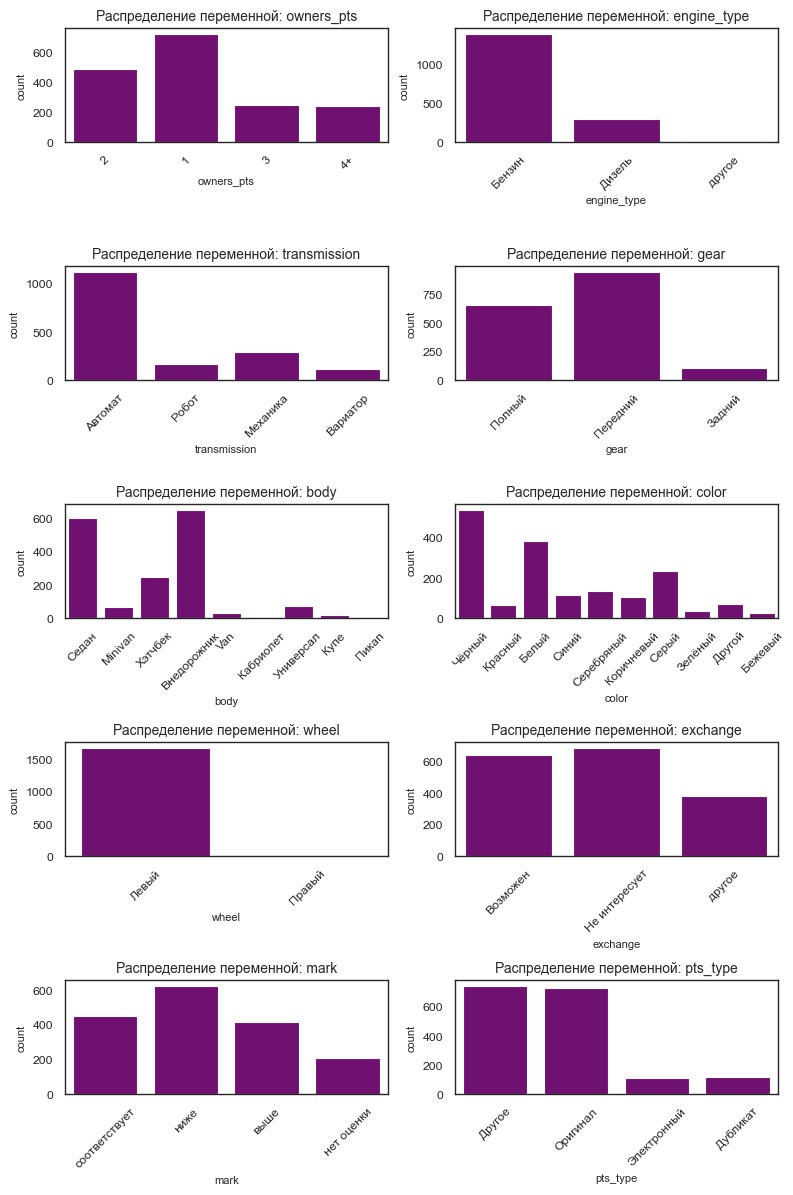

In [48]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(cat_cols_display):
    sns.countplot(data=df, x=col, ax=axes[i], color='purple') 
    axes[i].set_title(f'Распределение переменной: {col}') 
    axes[i].tick_params(axis='x', labelrotation=45)
    

plt.tight_layout()
plt.show()